# Feature selection for emotional speaker recognition on RAVDESS with XGBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  as GSCV
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, plot_confusion_matrix

import xgboost as xgb

import pickle

## Loading Data

In [ ]:
# Load eGeMAPSv01b features extrated with openSMILE
df = pd.read_csv('all_1440_eGeMAPSv01b.csv')

In [ ]:
# Separate features as X and speakers as y
feature_list = list(df.iloc[:, 7:])
X_features = df.iloc[:, 7:].to_numpy()
y_speakers = df['Speaker'].map(lambda x: x-1).to_numpy()

print("shape of X (88 features): ", X_features.shape)
print("shape of y (speakers): ", y_speakers.shape)

In [ ]:
# Split data into training and testing sets randomly
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_speakers, 
                                                    test_size=0.2, 
                                                    random_state=123)

## Building XGBoost Tree 🌲

To build a suitable XGBoost tree for classification, an important step is to find appropriate hyperparameters. Here we choose max depth, learning rate ('eta') and minimum loss reduction ('gamma') to tune with grid search and corss validation with scikit-learn module.

In [ ]:
# Build log loss evaluation metric for tuning with probabilities as input according to our model.
logloss_scorer = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

In [ ]:
# Hyper parameter grid to tune with.
hyparam_grid = {
    'max_depth' : [i for i in range(1, 4, 1)], 
    'eta' : [round(i, 2) for i in np.arange(0.28, 0.36, 0.01)], # lr
    'gamma' : [round(i, 2) for i in np.arange(0, 0.25, 0.05)], # 
    'min_child_weight': [round(i, 2) for i in np.arange(0.1, 0.35, 0.05)]
}

In [ ]:
# Find optimal hyper parameters with grid search and cross validation. 
# Use scoring method of log_loss which we built above.
# 'GSCV' is scikit-learn GridSearchCV function.
optimal_params = GSCV(
    estimator = xgb.XGBClassifier(objective="multi:softprob", seed=123), 
    param_grid=hyparam_grid, 
    scoring=logloss_scorer, 
    n_jobs=-1, 
    verbose=1,
    cv=5)

In [ ]:
# Apply the above grid search cross validation to training set
optimal_params.fit(X_train, y_train)

In [ ]:
# Print tuned best performing hyper parameters
evalute_result = optimal_params.cv_results_
optimal_params.best_params_

!!! OUTPUT: {'eta': 0.31, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 0.2}

## Train with tuned hyper-parameters

In this step we implement our optimized model and find its accuracy on test set.

In [ ]:
# Build a new tuned model with best-performing hyper parameters.
tuned_model = xgb.XGBClassifier(objective='multi:softprob', 
                                max_depth=2, 
                                eta=0.31, 
                                gamma=0, 
                                min_child_weight=0.2)

In [ ]:
# Fit training data to tuned model.
tuned_model.fit(X_train, y_train, 
                verbose=True)

In [ ]:
# Predict speaker ID with tuned model.
y_pred = tuned_model.predict(X_test)

In [204]:
# Calculate overall accuracy of predicted values on testing dataset.
confusion_mat = confusion_matrix(y_pred, y_test)
accu = np.sum(confusion_mat.diagonal()) / np.sum(confusion_mat)

print("Overall accuracy: ", round(accu*100, 2), "%")

Overall accuracy:  84.38 %


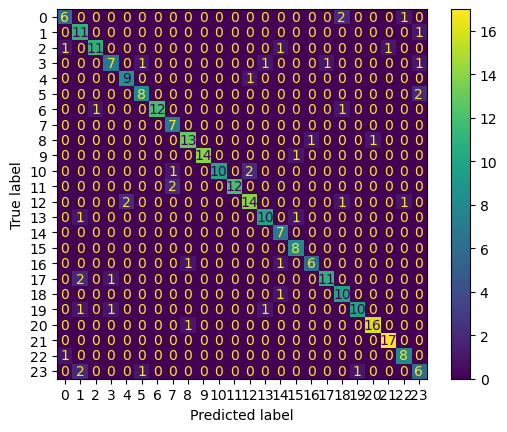

In [205]:
# Visualise confusion matrix.
plot_confusion_matrix(tuned_model, 
                      X_test, 
                      y_test)

plt.savefig('./confusion_matrix.png')
plt.show()

🤔 *looks pretty good...* 

In [272]:
# Save model
pickle.dump(tuned_model, open("tuned_xgboost_model.dat", 'wb'))

In [ ]:
# Load mreviousl saved model
with open("./tuned_xgboost_model.dat", 'rb') as f:
    tuned_model = pickle.load(f)

## Compute and plot feature importance

In [ ]:
importance = tuned_model.feature_importances_
importance_sorted = sorted(importance, reverse=True)

# get feature names by score indices
importance_index = importance.argsort()[::-1]
feature_by_importance = [feature_list[i] for i in importance_index]

# build a feature to importance dict for reference and later use
feat_dict = {}
for i, j in zip(feature_by_importance, importance_sorted):
    feat_dict[i] = j

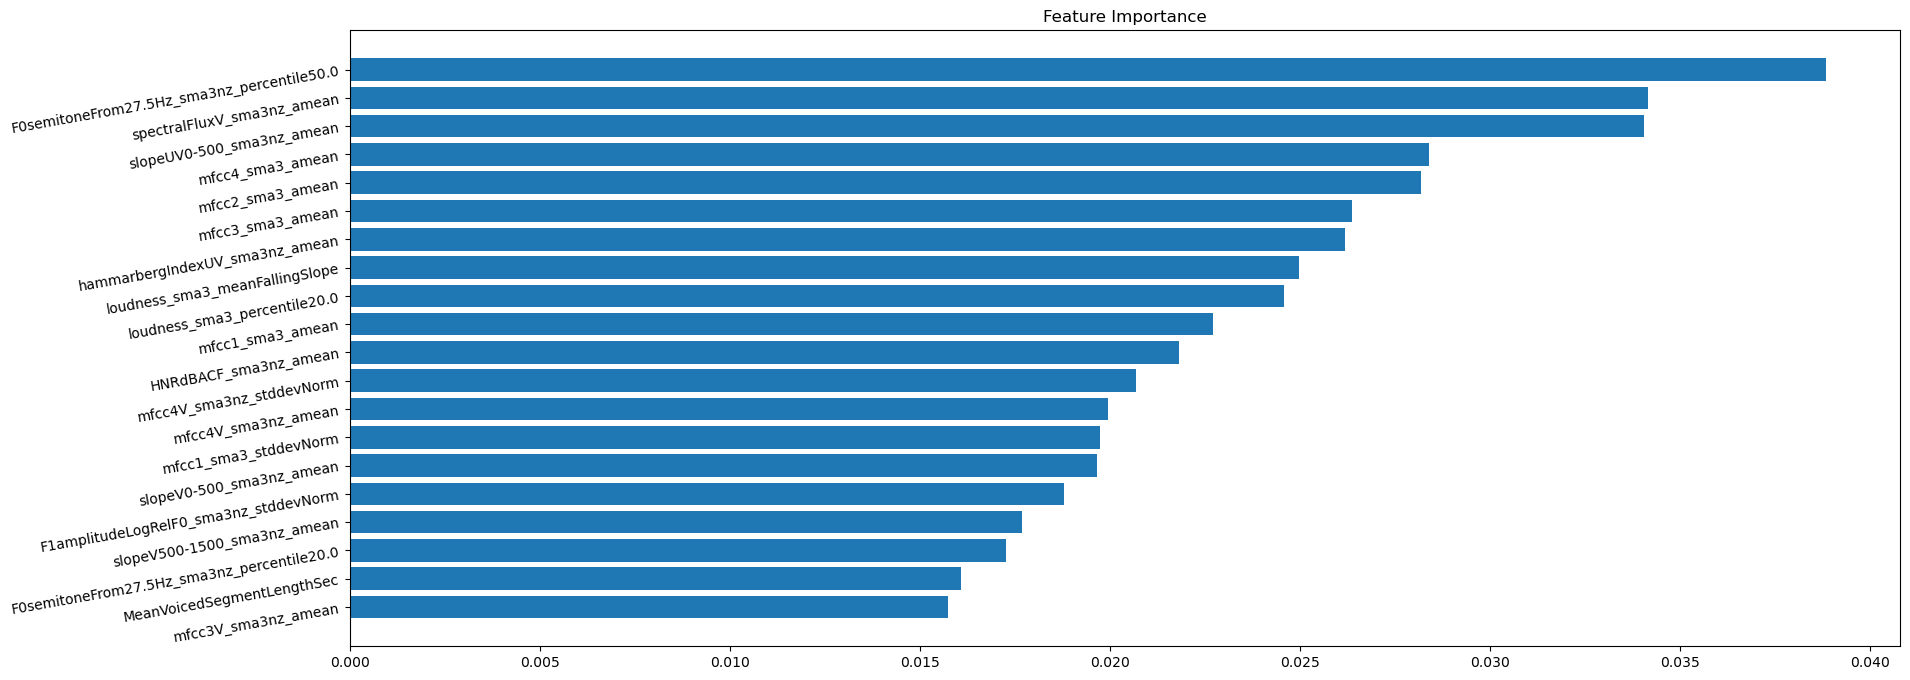

In [227]:
# Plot top 20 most important features.
fig, ax = plt.subplots(figsize=(20, 8))
plt.barh(np.arange(
                   len(feature_by_importance[:20])
                   ), 
                   importance_sorted[:20][::-1]
                   )
# plt.xticks(feature_by_importance[:12], rotation='vertical')
plt.yticks(np.arange(
                   len(feature_by_importance[:20])
                   ), 
                   feature_by_importance[:20][::-1],
                   rotation=10)
ax.set_title("Feature Importance")
plt.savefig('./feature_importance.png')
plt.show()

### Other feature importance algorithms

Note: these feature importance are calculated by XGBoost's "get_score" function instead of sklearn API feature_importance_ which only has "gain" as feature importance.

In [ ]:
# Build feature map
# Because didn't use xgb's own data structure DMatrix, .get_score would not return the actual labels, instead it returns "f0, f1, f2 ... f87". Here we build a dictionary to convert it back to readable format.
feature_num_form = []
for i in range(0, 88):
    feature_num_form.append('f'+str(i))

feature_map = dict(zip(feature_num_form, feature_list))

In [309]:
def feature_importance_algorithm(type):
    
    # get and sort importance scores
    feat = tuned_model.get_booster().get_score(importance_type=type)
    feat_reverse = {v : k for k, v in feat.items()}
    
    sorted_importance = sorted(list(feat.values()), reverse=True)
    
    # plotting
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # two dicts in a list gen ... a bit messy, just to replace f0, f1, ... lables with actual ones.
    actual_lables = [feature_map[feat_reverse[i]] for i in sorted_importance]

    # convert importance score to the ratio of immportance scores summed: 
    # score/sum(all_score)

    score_ratio = [round(i/sum(sorted_importance), 4) for i in sorted_importance]

    plt.barh(actual_lables[:20], score_ratio[:20])
    plt.yticks(rotation=10)
    ax.set_title("Feature Importance: " + type)
    plt.savefig("./feature_importance_" + type + ".png")
    plt.show()
    
    return actual_lables[:20], score_ratio[:20]

#### **Gain**, same as above, just to reaffirm everything's right

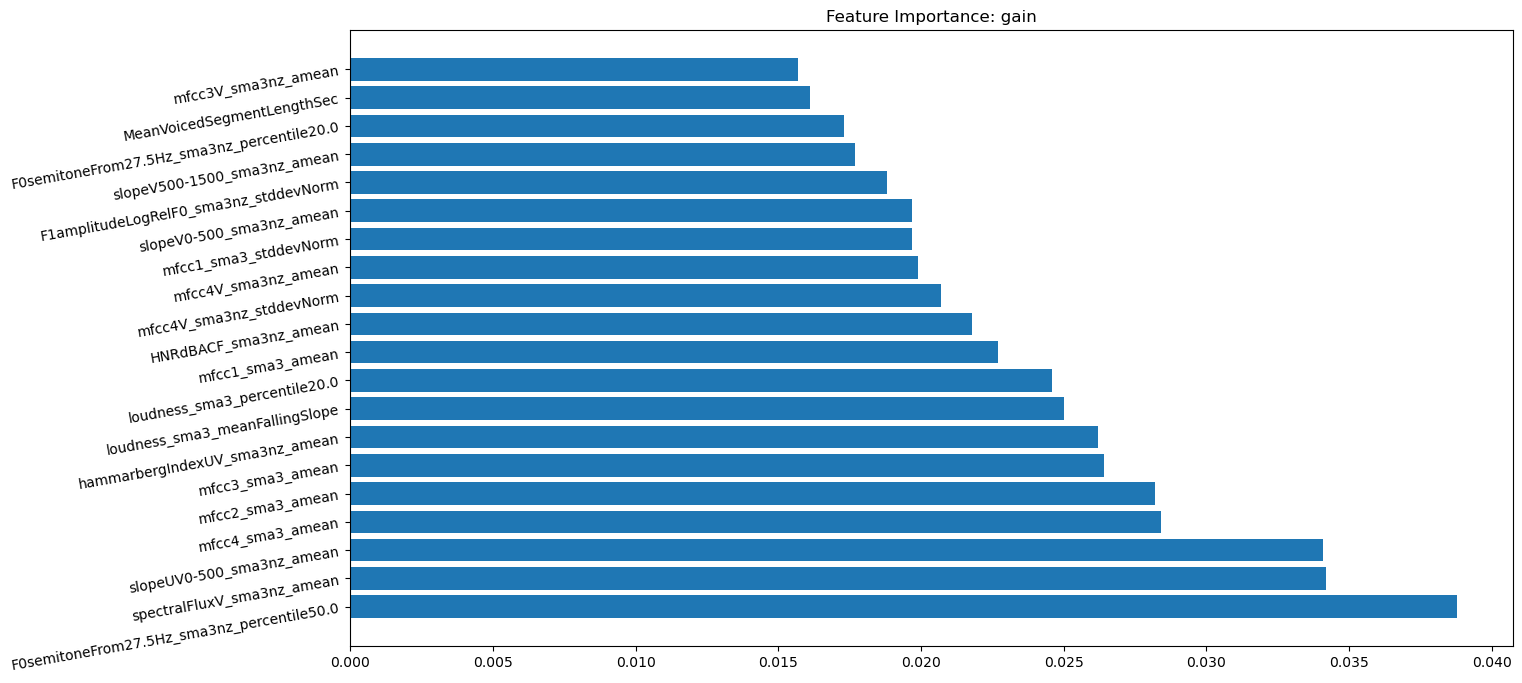

In [319]:
# It's the same as the sklearn result, so the labels and data are fine to move to other algorithms.
# feature_importance_algorithm('gain')
top_20_gain = feature_importance_algorithm('gain')[0] 

### Feature importance based on **weights**

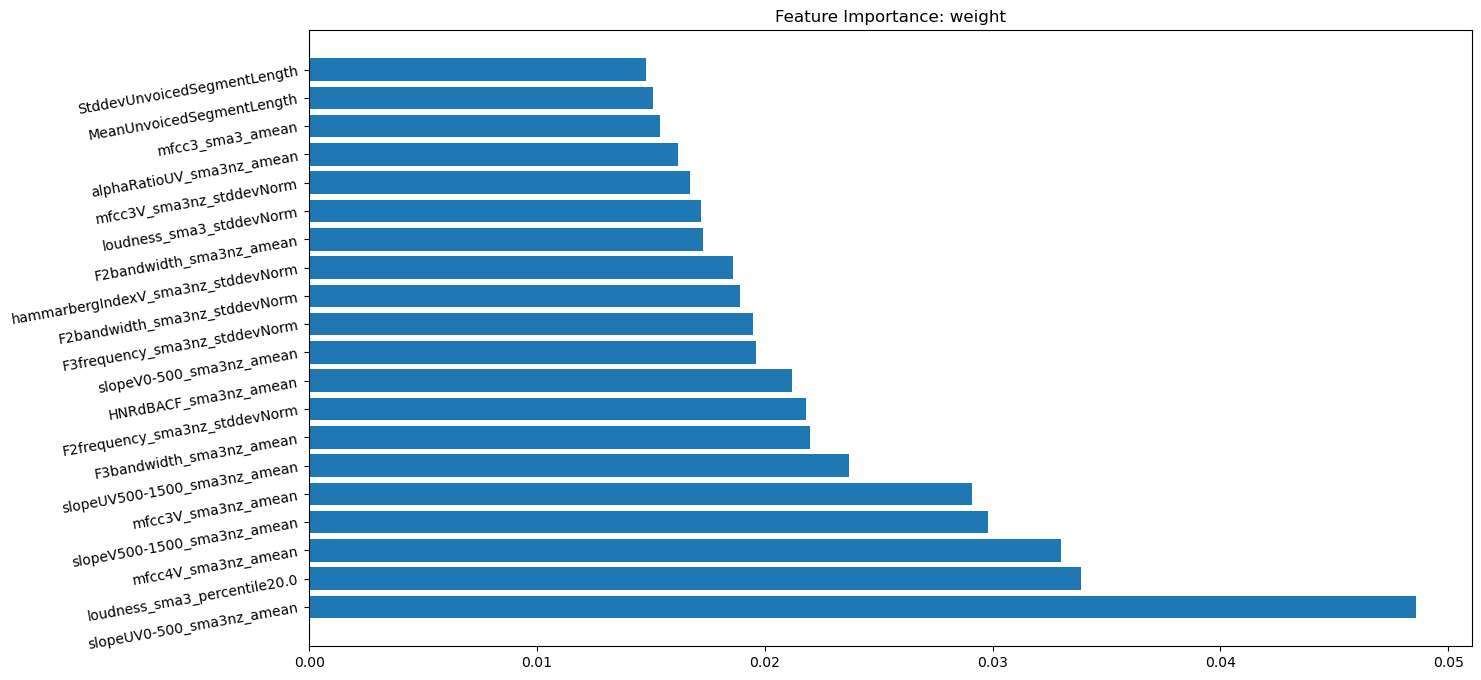

In [310]:
top_20_weight = feature_importance_algorithm('weight')[0]

### Feature importance based on **cover**

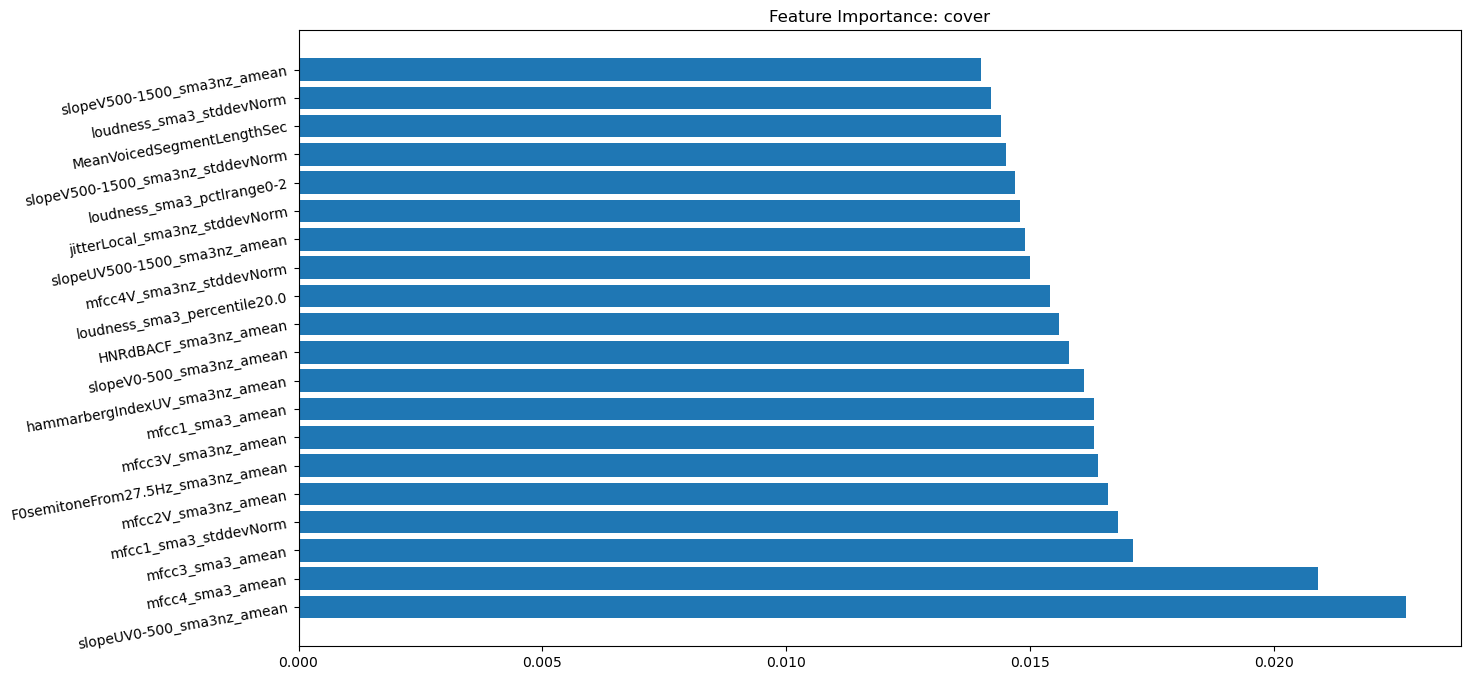

In [312]:
top_20_cover = feature_importance_algorithm('cover')[0]

### Feature importance based on total cover

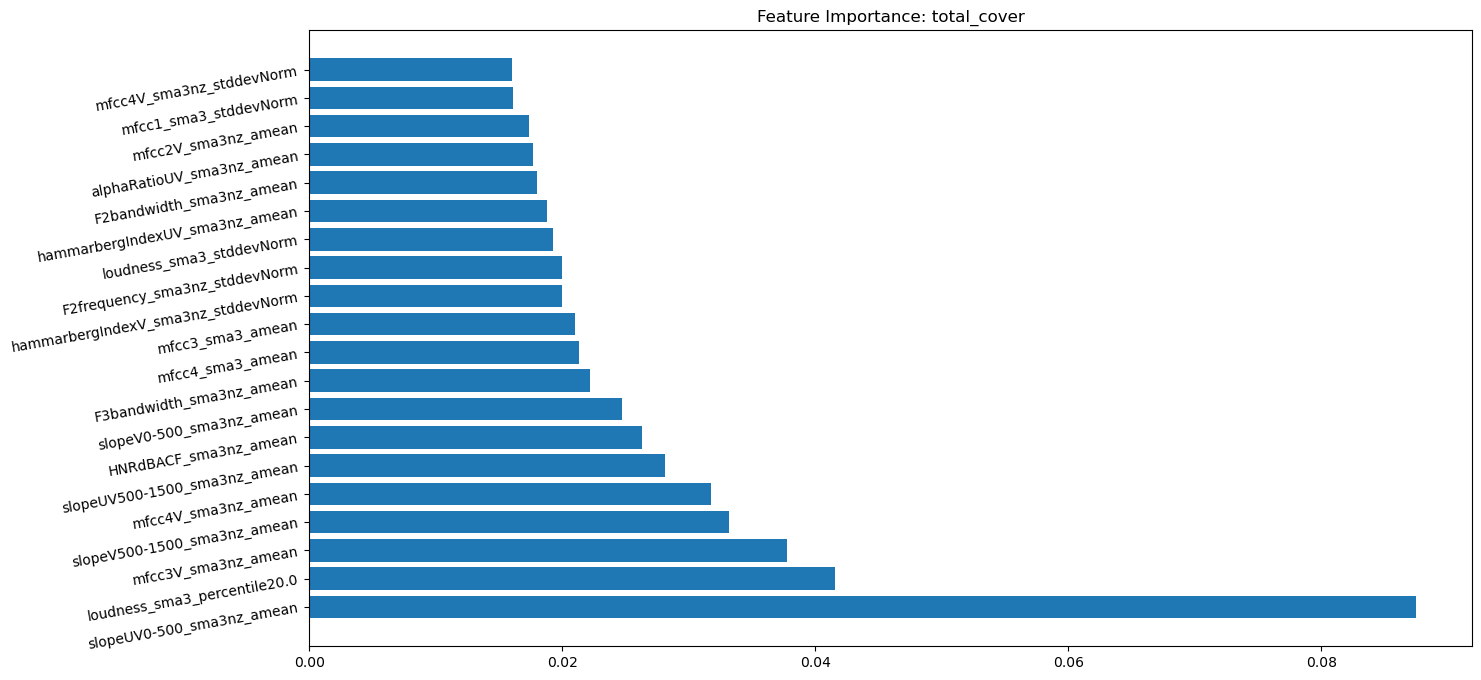

In [313]:
top_20_totalCover = feature_importance_algorithm('total_cover')[0]

### Feature importance based on total gain

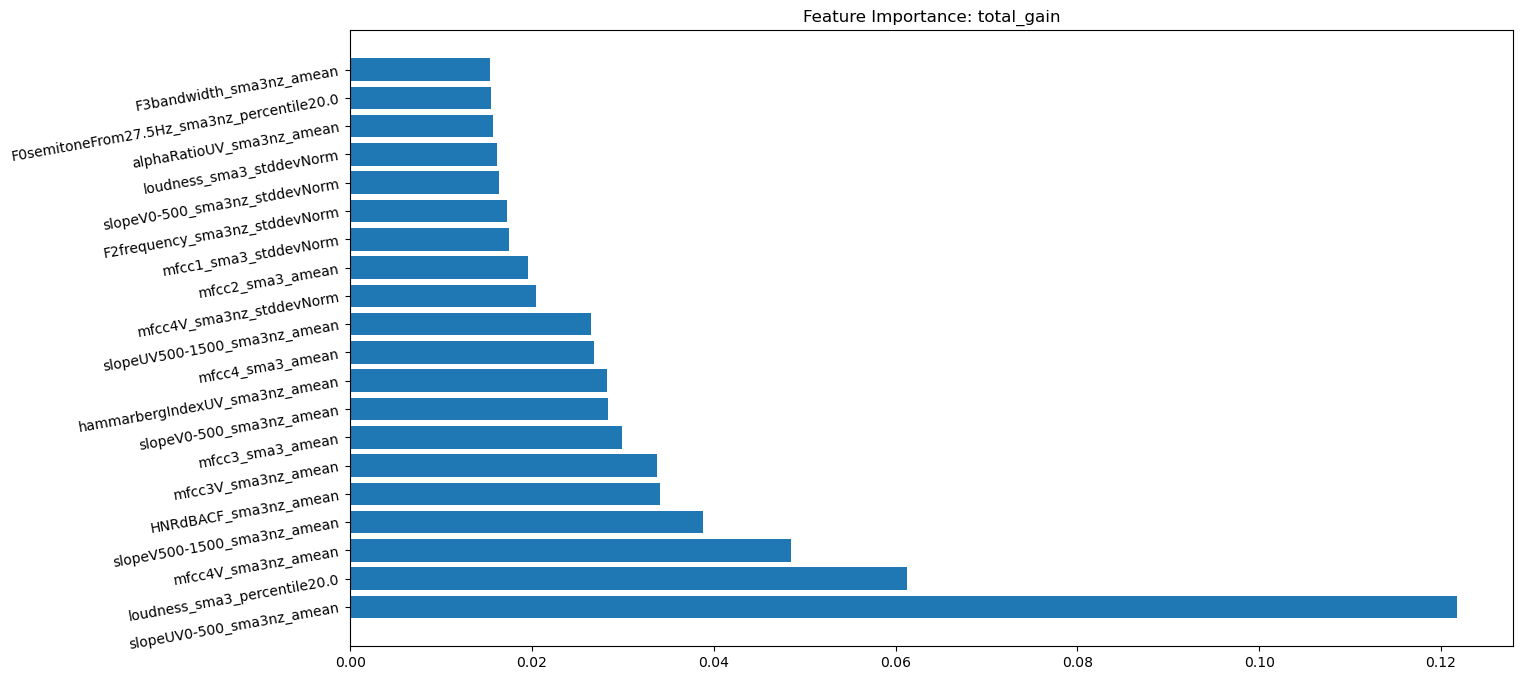

In [314]:
top_20_totalGain = feature_importance_algorithm('total_gain')[0]

### Compare and get final feature set

In [321]:
list(set(top_20_gain) & set(top_20_weight) & set(top_20_cover) & set(top_20_totalGain) & set(top_20_totalCover))

['mfcc3_sma3_amean',
 'slopeV0-500_sma3nz_amean',
 'mfcc3V_sma3nz_amean',
 'loudness_sma3_percentile20.0',
 'HNRdBACF_sma3nz_amean',
 'slopeV500-1500_sma3nz_amean',
 'slopeUV0-500_sma3nz_amean']

In [330]:
list(set(top_20_gain) | set(top_20_weight) | set(top_20_cover) | set(top_20_totalGain) | set(top_20_totalCover))

['mfcc3V_sma3nz_amean',
 'loudness_sma3_percentile20.0',
 'jitterLocal_sma3nz_stddevNorm',
 'slopeV500-1500_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'F2frequency_sma3nz_stddevNorm',
 'MeanVoicedSegmentLengthSec',
 'hammarbergIndexUV_sma3nz_amean',
 'slopeV500-1500_sma3nz_stddevNorm',
 'alphaRatioUV_sma3nz_amean',
 'StddevUnvoicedSegmentLength',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'mfcc1_sma3_stddevNorm',
 'F3bandwidth_sma3nz_amean',
 'loudness_sma3_pctlrange0-2',
 'F2bandwidth_sma3nz_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc1_sma3_amean',
 'F3frequency_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'mfcc4V_sma3nz_stddevNorm',
 'slopeUV500-1500_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F2bandwidth_sma3nz_amean',
 'loudness_sma3_stddevNorm',
 'slopeUV0-500_sma3nz_amean',
 'loudness_sma3_meanFallingSlope',
 'MeanUnvoicedSegmentLength',
 'mfcc4V_sma3nz_amean',
 'mfcc2_sma3_amean',
 'mfcc2V_sma3nz_amean',
 'slopeV0-500_sm